In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive')

# Finance dataset

AUNET on Finance Dataset

[*********************100%***********************]  1 of 1 completed

⚠️ No GPU found. Running on CPU.



[I 2025-04-12 17:22:05,851] A new study created in memory with name: no-name-67990a15-477e-4dff-85d1-2c694304cb24


✅ Finance dataset (S&P 500 Daily Closing Prices) prepared!
Training samples: 4624, Testing samples: 1157


<ipython-input-8-ead9be4347d8>:81: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform("l2_reg", 1e-6, 1e-4)
<ipython-input-8-ead9be4347d8>:82: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 5e-4)
[I 2025-04-12 17:23:24,957] Trial 0 finished with value: 0.001475695287808776 and parameters: {'num_heads': 6, 'units': 128, 'dropout_rate': 0.4928975256344408, 'num_dense_layers': 2, 'l2_reg': 1.1274973729987067e-06, 'learning_rate': 0.00019731744148797806}. Best is trial 0 with value: 0.001475695287808776.
[I 2025-04-12 17:25:01,693] Trial 1 finished with value: 0.0051665883511304855 a

Best Hyperparameters from Hyperband Optimization: {'num_heads': 6, 'units': 128, 'dropout_rate': 0.4928975256344408, 'num_dense_layers': 2, 'l2_reg': 1.1274973729987067e-06, 'learning_rate': 0.00019731744148797806}
Epoch 1/300
116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 3.4201 - val_loss: 1.1116
Epoch 2/300
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.5427 - val_loss: 1.1923
Epoch 3/300
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.8439 - val_loss: 0.7700
Epoch 4/300
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.6183 - val_loss: 0.3858
Epoch 5/300
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.4233 - val_loss: 0.1445
Epoch 6/300
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.2754 - val_loss: 0.0726
Epoch 7/300
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.1056 - val_loss: 0.0772
Epoch 8/300
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.9675 - val_loss: 0.0599
Epoch 9/300
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8307 - val_loss: 

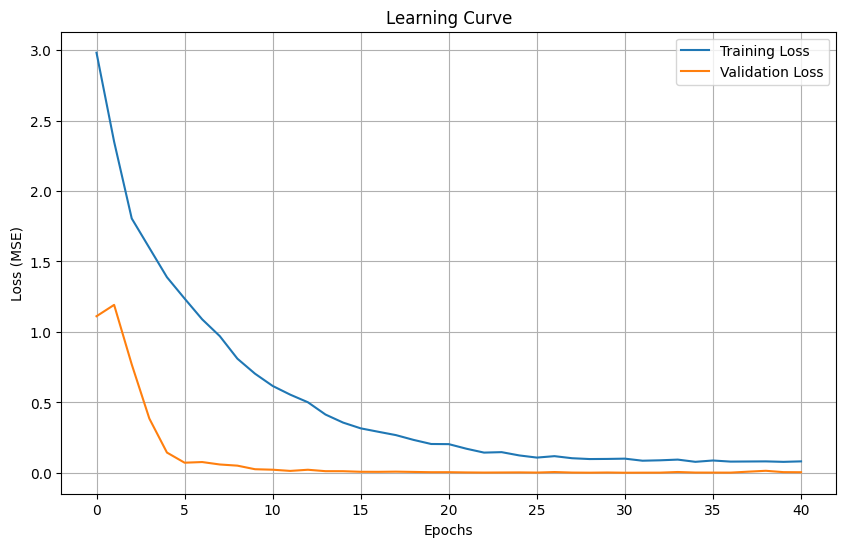

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

📌 Best Model Performance on S&P 500 Dataset:
MAE: 22.5436
RMSE: 31.1868
R² Score: 0.9990
MAPE: 1.32%


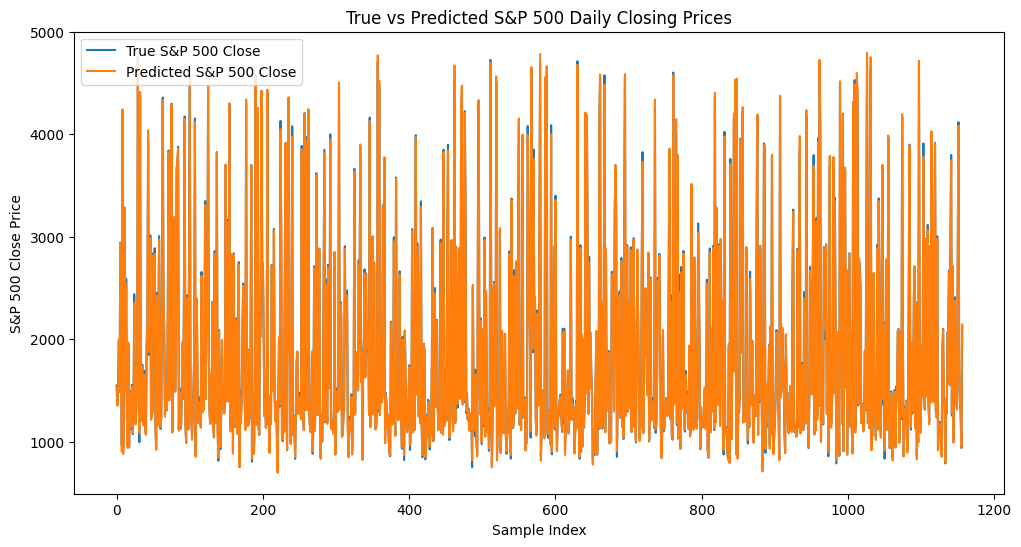

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import tensorflow as tf
import optuna
from optuna.integration import TFKerasPruningCallback
from tensorflow.keras import layers, models, optimizers, regularizers, callbacks
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ✅ Enable GPU in TensorFlow if available
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU is configured.")
    except RuntimeError as e:
        print(e)
else:
    print("⚠️ No GPU found. Running on CPU.")

# ✅ Download S&P 500 Daily Closing Prices using yfinance
ticker = '^GSPC'
start_date = '2000-01-01'
end_date = '2022-12-31'
sp500 = yf.download(ticker, start=start_date, end=end_date)
sp500.reset_index(inplace=True)

# Keep only the necessary columns and convert Date to datetime
sp500 = sp500[['Date', 'Close']]
sp500["Date"] = pd.to_datetime(sp500["Date"])

# ✅ Feature Engineering: Extract Date Features and Create Lag/Rolling Statistics
sp500["year"] = sp500["Date"].dt.year
sp500["month"] = sp500["Date"].dt.month
sp500["day"] = sp500["Date"].dt.day
sp500["dayofweek"] = sp500["Date"].dt.dayofweek
sp500["dayofyear"] = sp500["Date"].dt.dayofyear

# Create lag features
sp500["lag1"] = sp500["Close"].shift(1)
sp500["lag2"] = sp500["Close"].shift(2)

# Create rolling window features
sp500["rolling_mean_3"] = sp500["Close"].rolling(window=3).mean()
sp500["rolling_mean_7"] = sp500["Close"].rolling(window=7).mean()

# Remove rows with missing values generated by shifting/rolling
sp500 = sp500.dropna()

# ✅ Normalize the Target and Feature Columns
target_scaler = StandardScaler()
sp500["Close_norm"] = target_scaler.fit_transform(sp500[["Close"]])

feature_columns = [
    "lag1", "lag2", "rolling_mean_3", "rolling_mean_7",
    "year", "month", "day", "dayofweek", "dayofyear"
]
feature_scaler = StandardScaler()
sp500[feature_columns] = feature_scaler.fit_transform(sp500[feature_columns])

# Prepare features and target arrays
features = sp500[feature_columns].values
target = sp500["Close_norm"].values

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
print("✅ Finance dataset (S&P 500 Daily Closing Prices) prepared!")
print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

# ✅ Define the AUNET Model with Hyperparameter Search using Optuna
def create_model(trial):
    # Define hyperparameter search space
    num_heads = trial.suggest_int("num_heads", 4, 8)
    units = trial.suggest_categorical("units", [128, 256])
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.5)
    num_dense_layers = trial.suggest_int("num_dense_layers", 2, 4)
    l2_reg = trial.suggest_loguniform("l2_reg", 1e-6, 1e-4)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 5e-4)

    # Model architecture
    inputs = layers.Input(shape=(features.shape[1],))
    # Reshape input to be suitable for multihead attention (batch, time steps, features)
    reshaped_inputs = layers.Reshape((1, features.shape[1]))(inputs)
    attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=units)(
        reshaped_inputs, reshaped_inputs
    )

    x = attention_output
    for _ in range(num_dense_layers):
        x = layers.Dense(units, activation="relu", kernel_regularizer=regularizers.l2(l2_reg))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropout_rate)(x)

    x = layers.Dense(1)(x)
    outputs = layers.Flatten()(x)
    model = models.Model(inputs, outputs)

    # Compile the model with Adam optimizer and MSE loss
    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss="mse")
    return model

# Define the objective function for hyperparameter tuning
def objective(trial):
    device = "/GPU:0" if tf.config.list_physical_devices("GPU") else "/CPU:0"
    with tf.device(device):
        model = create_model(trial)
        early_stopping = callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
        pruning_callback = TFKerasPruningCallback(trial, "val_loss")

        history = model.fit(
            X_train, y_train,
            epochs=300,
            validation_split=0.2,
            batch_size=32,
            callbacks=[early_stopping, pruning_callback],
            verbose=0
        )
        return min(history.history["val_loss"])

# Run Optuna Hyperband Tuning
study = optuna.create_study(direction="minimize", pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective, n_trials=50)
print("Best Hyperparameters from Hyperband Optimization:", study.best_params)

# ✅ Train the Best Model on the Full Training Set and capture learning history
device = "/GPU:0" if tf.config.list_physical_devices("GPU") else "/CPU:0"
with tf.device(device):
    best_model = create_model(optuna.trial.FixedTrial(study.best_params))
    history = best_model.fit(
        X_train, y_train,
        epochs=300,
        validation_split=0.2,
        batch_size=32,
        callbacks=[callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)],
        verbose=1
    )

# ✅ Plot Learning Curve (Training & Validation Loss)
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Learning Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()

# ✅ Evaluate the Best Model on the Test Set
y_pred = best_model.predict(X_test)
# Inverse transform predictions and true values
y_pred_denorm = target_scaler.inverse_transform(y_pred)
y_test_denorm = target_scaler.inverse_transform(y_test.reshape(-1, 1))

mae = mean_absolute_error(y_test_denorm, y_pred_denorm)
rmse = np.sqrt(mean_squared_error(y_test_denorm, y_pred_denorm))
r2 = r2_score(y_test_denorm, y_pred_denorm)
mape = np.mean(np.abs((y_test_denorm - y_pred_denorm) / np.maximum(np.abs(y_test_denorm), 1e-8))) * 100

print("\n📌 Best Model Performance on S&P 500 Dataset:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")

# Optional: Plot the true vs predicted S&P 500 Close values
plt.figure(figsize=(12, 6))
plt.plot(y_test_denorm, label="True S&P 500 Close")
plt.plot(y_pred_denorm, label="Predicted S&P 500 Close")
plt.title("True vs Predicted S&P 500 Daily Closing Prices")
plt.xlabel("Sample Index")
plt.ylabel("S&P 500 Close Price")
plt.legend()
plt.show()


AUNET on Healthcare Dataset

⚠️ No GPU found. Running on CPU.


[I 2025-04-12 18:17:58,967] A new study created in memory with name: no-name-d54c0f6c-e587-4453-bf33-40e239dcdcbc


✅ Healthcare dataset (OWID COVID-19 New Cases for United States) prepared!
Training samples: 980, Testing samples: 246


<ipython-input-11-0f7a6a0917d2>:104: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform("l2_reg", 1e-6, 1e-4)
<ipython-input-11-0f7a6a0917d2>:105: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 5e-4)
[I 2025-04-12 18:18:34,499] Trial 0 finished with value: 0.18341286480426788 and parameters: {'num_heads': 8, 'units': 256, 'dropout_rate': 0.20062687756599892, 'num_dense_layers': 3, 'l2_reg': 1.021219543696702e-05, 'learning_rate': 0.00029037504965195187}. Best is trial 0 with value: 0.18341286480426788.
[I 2025-04-12 18:18:55,775] Trial 1 finished with value: 0.15510720014572144 a

Best Hyperparameters from Hyperband Optimization: {'num_heads': 6, 'units': 128, 'dropout_rate': 0.2155484321906188, 'num_dense_layers': 2, 'l2_reg': 1.3057734162106741e-05, 'learning_rate': 0.00015949414156683363}
Epoch 1/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 2.8472 - val_loss: 1.1934
Epoch 2/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.0322 - val_loss: 1.1727
Epoch 3/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.4037 - val_loss: 1.1486
Epoch 4/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.2147 - val_loss: 1.1125
Epoch 5/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.8755 - val_loss: 1.0930
Epoch 6/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.1741 - val_loss: 1.0460
Epoch 7/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.9008 - val_loss: 1.0030
Epoch 8/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8882 - val_loss: 0.9518
Epoch 9/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0613 - val_loss: 0.8727
Epoch 10/30

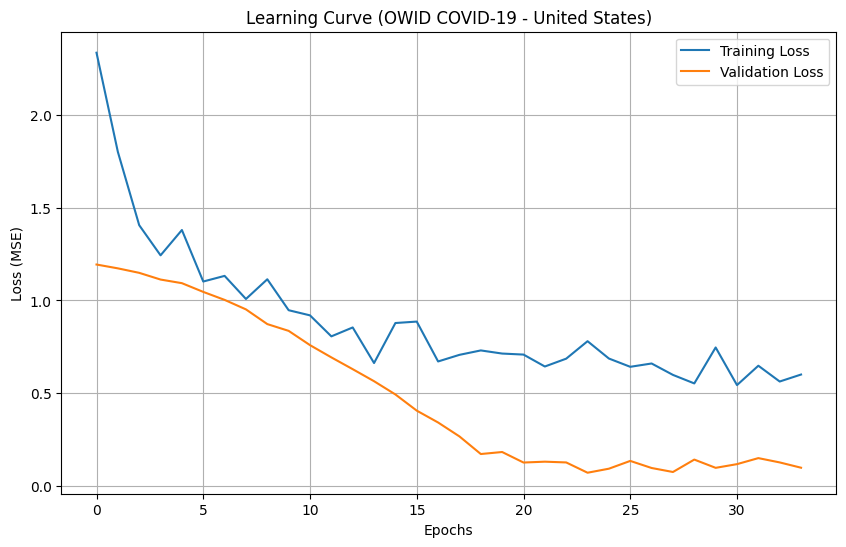

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

📌 Best Model Performance on OWID COVID-19 (United States New Cases) Dataset:
MAE: 59957.6022
RMSE: 85172.6662
R² Score: 0.9535
MAPE: 413964842625674.88%


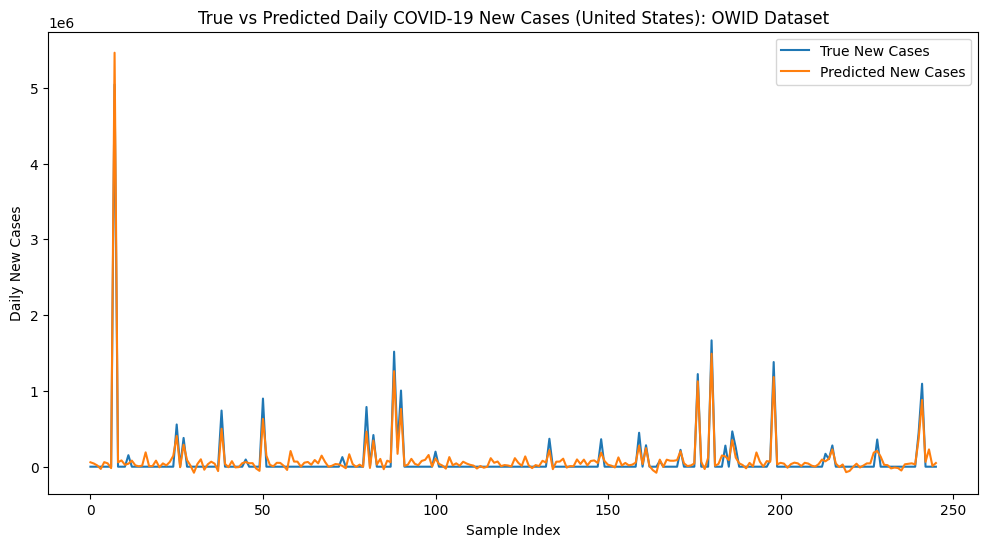

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import optuna
from optuna.integration import TFKerasPruningCallback
from tensorflow.keras import layers, models, optimizers, regularizers, callbacks
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ✅ Enable GPU in TensorFlow if available
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU is configured.")
    except RuntimeError as e:
        print(e)
else:
    print("⚠️ No GPU found. Running on CPU.")

# ============================================================================
# 1. Load and Preprocess OWID COVID-19 Dataset
# ============================================================================

# Fetch the dataset directly from Our World in Data
url = "https://covid.ourworldindata.org/data/owid-covid-data.csv"
data = pd.read_csv(url)

# Filter for a specific country (e.g., "United States")
country = "United States"
data_country = data[data["location"] == country].copy()

# Convert 'date' to datetime format and sort
data_country["date"] = pd.to_datetime(data_country["date"], format="%Y-%m-%d")
data_country = data_country.sort_values("date")

# Use the daily new cases as the univariate target (drop missing values)
data_country = data_country[["date", "new_cases"]].dropna()

# Optionally, remove negative or zero values if desired (here we keep all values)
# data_country = data_country[data_country["new_cases"] > 0]

# ============================================================================
# 2. Feature Engineering: Date Features, Lags & Rolling Averages
# ============================================================================

# Extract date-based features
data_country["year"]      = data_country["date"].dt.year
data_country["month"]     = data_country["date"].dt.month
data_country["day"]       = data_country["date"].dt.day
data_country["dayofweek"] = data_country["date"].dt.dayofweek
data_country["dayofyear"] = data_country["date"].dt.dayofyear

# Create lag features
data_country["lag1"] = data_country["new_cases"].shift(1)
data_country["lag2"] = data_country["new_cases"].shift(2)

# Create rolling window features (3-day and 7-day rolling means)
data_country["rolling_mean_3"] = data_country["new_cases"].rolling(window=3).mean()
data_country["rolling_mean_7"] = data_country["new_cases"].rolling(window=7).mean()

# Drop rows with missing values caused by shifting/rolling
data_country = data_country.dropna()

# ============================================================================
# 3. Normalize Target and Feature Columns
# ============================================================================

# Normalize the target: daily new cases
target_scaler = StandardScaler()
data_country["new_cases_norm"] = target_scaler.fit_transform(data_country[["new_cases"]])

# Define feature columns: lags, rolling means, and date components
feature_columns = ["lag1", "lag2", "rolling_mean_3", "rolling_mean_7",
                   "year", "month", "day", "dayofweek", "dayofyear"]
feature_scaler = StandardScaler()
data_country[feature_columns] = feature_scaler.fit_transform(data_country[feature_columns])

# Prepare features and target arrays
features = data_country[feature_columns].values
target = data_country["new_cases_norm"].values

# ============================================================================
# 4. Split into Training and Testing Sets
# ============================================================================

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
print("✅ Healthcare dataset (OWID COVID-19 New Cases for {}) prepared!".format(country))
print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

# ============================================================================
# 5. Define the AUNET Model with Hyperparameter Tuning (Optuna)
# ============================================================================

def create_model(trial):
    # Define hyperparameter search space
    num_heads = trial.suggest_int("num_heads", 4, 8)
    units = trial.suggest_categorical("units", [128, 256])
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.5)
    num_dense_layers = trial.suggest_int("num_dense_layers", 2, 4)
    l2_reg = trial.suggest_loguniform("l2_reg", 1e-6, 1e-4)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 5e-4)

    # Model architecture
    inputs = layers.Input(shape=(features.shape[1],))
    # Reshape input to be suitable for multihead attention (batch, time steps, features)
    reshaped_inputs = layers.Reshape((1, features.shape[1]))(inputs)
    attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=units)(
        reshaped_inputs, reshaped_inputs
    )

    x = attention_output
    for _ in range(num_dense_layers):
        x = layers.Dense(units, activation="relu", kernel_regularizer=regularizers.l2(l2_reg))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropout_rate)(x)

    x = layers.Dense(1)(x)
    outputs = layers.Flatten()(x)
    model = models.Model(inputs, outputs)

    # Compile the model using the Adam optimizer and MSE loss
    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss="mse")
    return model

def objective(trial):
    device = "/GPU:0" if tf.config.list_physical_devices("GPU") else "/CPU:0"
    with tf.device(device):
        model = create_model(trial)
        early_stopping = callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
        pruning_callback = TFKerasPruningCallback(trial, "val_loss")

        history = model.fit(
            X_train, y_train,
            epochs=300,
            validation_split=0.2,
            batch_size=32,
            callbacks=[early_stopping, pruning_callback],
            verbose=0
        )
        return min(history.history["val_loss"])

# Run hyperparameter tuning using Optuna Hyperband Pruner
study = optuna.create_study(direction="minimize", pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective, n_trials=50)
print("Best Hyperparameters from Hyperband Optimization:", study.best_params)

# ============================================================================
# 6. Train the Best Model on the Full Training Set and Capture Learning History
# ============================================================================

device = "/GPU:0" if tf.config.list_physical_devices("GPU") else "/CPU:0"
with tf.device(device):
    best_model = create_model(optuna.trial.FixedTrial(study.best_params))
    history = best_model.fit(
        X_train, y_train,
        epochs=300,
        validation_split=0.2,
        batch_size=32,
        callbacks=[callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)],
        verbose=1
    )

# ============================================================================
# 7. Plot the Learning Curve (Training & Validation Loss)
# ============================================================================

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Learning Curve (OWID COVID-19 - {})".format(country))
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()

# ============================================================================
# 8. Evaluate the Model on the Test Set and Compute Error Metrics
# ============================================================================

y_pred = best_model.predict(X_test)
# Inverse transform predictions and true values to their original scale
y_pred_denorm = target_scaler.inverse_transform(y_pred)
y_test_denorm = target_scaler.inverse_transform(y_test.reshape(-1, 1))

mae  = mean_absolute_error(y_test_denorm, y_pred_denorm)
rmse = np.sqrt(mean_squared_error(y_test_denorm, y_pred_denorm))
mape = np.mean(np.abs((y_test_denorm - y_pred_denorm) / np.maximum(np.abs(y_test_denorm), 1e-8))) * 100
r2   = r2_score(y_test_denorm, y_pred_denorm)

print("\n📌 Best Model Performance on OWID COVID-19 ({} New Cases) Dataset:".format(country))
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")

# ============================================================================
# 9. Plot True vs. Predicted Values
# ============================================================================

plt.figure(figsize=(12, 6))
plt.plot(y_test_denorm, label="True New Cases")
plt.plot(y_pred_denorm, label="Predicted New Cases")
plt.title("True vs Predicted Daily COVID-19 New Cases ({}): OWID Dataset".format(country))
plt.xlabel("Sample Index")
plt.ylabel("Daily New Cases")
plt.legend()
plt.show()
